# Postsynaptic profiles analysis

---

Postsynaptic glutamatergic neurons with rGeco

In [1]:
import sys
import os
import yaml

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
from numpy import ma
import numpy.polynomial.polynomial as poly

import pandas as pd
import peakutils

from scipy import signal
from scipy import stats
from scipy import ndimage
from scipy.ndimage import measurements
from scipy import signal
from scipy import ndimage as ndi

from skimage import io
from sklearn import preprocessing
from skimage import filters
from skimage import measure
from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

## Full frame analysis

### Data & metadata uploading

#### Multiple data

In [13]:
class PostReg():
    """ Presynapse full-frame registration

    """
    def __init__(self, samp_name):
        self.samp_name = samp_name
        self.samp_path = os.path.join(''.join(sys.path[0].split('neuro')), 'data_neuro', samp_name)
        
        self.samp_plot_save_path = f'{self.samp_path}/post_plot'
        if not os.path.exists(self.samp_plot_save_path):
             os.makedirs(self.samp_plot_save_path)

        self.img_series = io.imread(f'{self.samp_path}/{self.samp_name}_post_mov_cor.tif')
        self.total_prof = np.asarray([np.mean(frame) for frame in self.img_series])

        with open(f'{self.samp_path}/{self.samp_name}_meta.yaml') as f:
            self.samp_meta = yaml.safe_load(f)

        self.total_reg_t = self.samp_meta['Reg_time']
        self.frame_time = self.total_reg_t / self.img_series.shape[0]
        self.time_line = np.linspace(0, self.total_reg_t, num=self.img_series.shape[0])

        print(f'{self.samp_name} ({self.samp_meta["Treat"]})')
        self.treat_dict, self.app_line_dict = self.treat_calc(self.samp_meta)


    @staticmethod
    def treat_calc(samp_meta):
        treat_dict = {}
        for samp in samp_meta['Events']:
            treat_name = f"{samp['Type']}_{samp['Freq']}"
            start_time = samp['Time']/1000
            end_time = start_time + samp['Duration']
            treat_dict.update({treat_name:[start_time, end_time]})
        for k,v in treat_dict.items():  # app time print
            print(k, ':', np.around(v, 1))

        application_lines_dict = {t:np.linspace(treat_dict[t][0], treat_dict[t][1]) \
                                  for t in treat_dict}
    
        return treat_dict, application_lines_dict
    

    @staticmethod
    def label_contour_pic(img, label, title, save_path=False):

        plt.figure(figsize=(15,10))
        plt.imshow(img, cmap='magma')
        ax = plt.gca()

        for l_num in range(1, np.max(label)+1): 
            l_mask = label == l_num
            l_center = measurements.center_of_mass(l_mask)
            l_contour = np.asarray(measure.find_contours(l_mask, level=0.5))

            # plt.imshow(l_mask, cmap='jet', alpha=.5)
            color = next(ax._get_lines.prop_cycler)['color']
            for cont in l_contour:            
                plt.plot(cont[:, 1], cont[:, 0], linewidth=2, color=color)
            plt.annotate(f'ROI {l_num}',
                        (l_center[1], l_center[0]),
                        textcoords="offset points",
                        xytext=(2,2),
                        ha='center',
                        color=color,
                        weight='bold',
                        fontsize=10)
        plt.title(title)
        plt.axis('off')
        plt.tight_layout()
        if save_path:
             plt.savefig(save_path, dpi=300)
        else:
            plt.show()


    @staticmethod
    def cascade_prof_plot(prof_dict, time, line_dict, title, y_shift=0.5, save_path=False):
        time_bar = int(200 * (max(time)/len(time)))

        plt.figure(figsize=(10, 4))

        # profiles plotting
        shift = 0
        for soma_num in prof_dict.keys():
            soma_prof = prof_dict[soma_num]
            plt.plot(time, soma_prof+shift, alpha=.3, label=f'ROI {soma_num}')
            shift -= y_shift

        # bars plotting
        first_prof_max = np.array(prof_dict[1]).max()
        print(first_prof_max)
        print(type(first_prof_max))

        for line_name in line_dict:
            line_lim = line_dict[line_name]
            plt.plot(line_lim, [first_prof_max+0.05] * len(line_lim), label=line_name, linewidth=4)

        plt.vlines(x=[-10], ymin=[first_prof_max-(0.25+0.15)], ymax=[first_prof_max+0.15], linewidth=3, color='k')
        # plt.text(x=-30, y=-0.2, s="100% ΔF/F", size=15, rotation=90.)

        plt.hlines(y=[first_prof_max+0.15], xmin=[-10], xmax=[time_bar-10], linewidth=3, color='k')
        # plt.text(x=30, y=-1.15, s="200 s", size=15)

        plt.suptitle(title)
        plt.title('x bar - 200s, y bar - 25% ΔF/F', loc='left')
        plt.axis('off')
        plt.legend(loc=1)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        else:
            plt.show()
    

    def plot_tot_profile(self, save_debug_plot=False):
        plt.figure(figsize=(10, 4))
        plt.plot(self.time_line, self.total_prof)

        for line_name in self.app_line_dict:
                line_lim = self.app_line_dict[line_name]
                plt.plot(line_lim, [np.min(self.total_prof)] * len(line_lim),
                         label=line_name, linewidth=4)

        plt.xlabel('Time, s')
        plt.ylabel('I, a.u.')
        plt.title(f'{self.samp_name} ({self.samp_meta["Treat"]}) full-frame profile')    
        plt.tight_layout()    
        plt.legend()
        if save_debug_plot:
                plt.savefig(f'{self.samp_plot_save_path}/{self.samp_name}_total_prof.png', dpi=300)
        else:
            plt.show()
        plt.close()


    def soma_mask(self, min_soma_area=200):
        self.soma_det_img = filters.gaussian(np.max(self.img_series, axis=0), sigma=1.5)
        th_otsu = filters.threshold_otsu(self.soma_det_img)

        raw_mask = self.soma_det_img > th_otsu
        raw_label = measure.label(raw_mask)

        area_dict = {}
        area_th = min_soma_area
        for label_number in range(1, np.max(raw_label)):
            one_label_mask = raw_label == label_number
            one_label_area = np.sum(one_label_mask)
            
            if one_label_area >= area_th:
                label_area_dict = {label_number:one_label_area}
                area_dict.update(label_area_dict)

        fin_mask = np.zeros_like(raw_label)
        for lable_key in area_dict.keys():
            key_mask = raw_label == lable_key
            fin_mask = fin_mask + key_mask
        self.fin_mask = measure.label(morphology.dilation(fin_mask, footprint=morphology.disk(6)))

        distance = ndi.distance_transform_cdt(self.fin_mask, metric='taxicab')
        coords = peak_local_max(distance, min_distance=15, footprint=morphology.disk(15), labels=self.fin_mask)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndi.label(mask)
        self.soma_label = watershed(-distance, markers, mask=self.fin_mask)
        soma_mask = self.soma_label != 0

        self.label_contour_pic(self.soma_det_img, self.soma_label,
                               title=f'{self.samp_name} ({self.samp_meta["Treat"]}) soma contours',
                               save_path=f'{self.samp_plot_save_path}/{self.samp_name}_soma cont.png') 


    def soma_profiles(self, soma_label=False):
        # if ~isinstance(soma_label, (np.ndarray, np.generic)):
        #      soma_label = self.soma_label

        self.soma_raw_prof_dict = {}
        self.soma_dF_prof_dict = {}
        for label_number in range(1, np.max(soma_label)+1):
             mask = soma_label == label_number
             prof = np.asarray([np.mean(ma.masked_where(~mask, frame)) for frame in self.img_series])
             prof_base = peakutils.baseline(prof, 3)
             prof = (prof-prof_base) + np.mean(prof_base)
             F_0 = np.mean(prof[:8])
             dF_prof = (prof-F_0)/F_0

             self.soma_raw_prof_dict.update({label_number:np.asarray(prof)})
             self.soma_dF_prof_dict.update({label_number:np.asarray(dF_prof)})

        self.cascade_prof_plot(prof_dict=self.soma_dF_prof_dict, time=self.time_line,
                               line_dict=self.app_line_dict,
                               title=f'{self.samp_name} ({self.samp_meta["Treat"]}) soma profiles',
                               save_path=f'{self.samp_plot_save_path}/{self.samp_name}_soma cascade.png')


    def LF_stims(self, stim_ext_sec=15, LF_min_distance_sec=8, save_debug_plot=False):
        """ Extraction of low-frequency stimulation (0.1 Hz)

        """
        self.LF_min_distance_frames = int(LF_min_distance_sec / self.frame_time)
        if self.LF_min_distance_frames < 1:
            self.LF_min_distance_frames = 1

        self.LF_dF_stim_prof = {}
        self.LF_stim_df = pd.DataFrame(columns=['stim',
                                                'amp_raw',
                                                'amp_dF'])

        for line_name in self.treat_dict:
                if line_name in ['A+C_0.1', 'C_0.1']:
                        t_lim = self.treat_dict[line_name]
                        time_mask = (self.time_line>=(t_lim[0]-stim_ext_sec)) & \
                                    (self.time_line<=(t_lim[1]+stim_ext_sec))

                        stim_prof_raw = self.total_prof[time_mask]
                        stim_prof_base = peakutils.baseline(stim_prof_raw, 4)
                        stim_prof = (stim_prof_raw - stim_prof_base) \
                                     + np.mean(stim_prof_base)
                        stim_time = self.time_line[:len(stim_prof-3)]

                        F_0 = np.mean(stim_prof[:stim_ext_sec])
                        dF_stim_prof = (stim_prof-F_0)/F_0
                        dF_stim_prof_raw = (stim_prof_raw-np.mean(stim_prof_raw[:stim_ext_sec]))\
                                            / np.mean(stim_prof_raw[:10])
                        self.LF_dF_stim_prof.update({line_name:dF_stim_prof})

                        peaks, properties = signal.find_peaks(dF_stim_prof,
                                                              height=np.max(dF_stim_prof)*0.25,
                                                              distance=self.LF_min_distance_frames)
                        
                        stim_df = pd.DataFrame({'stim':np.full(len(peaks), line_name),
                                                'amp_raw':stim_prof[peaks],
                                                'amp_dF':dF_stim_prof[peaks]})
                        self.LF_stim_df = pd.concat([self.LF_stim_df, stim_df],
                                                    ignore_index=True)

                        plt.figure(figsize=(10, 4))
                        plt.plot(stim_time, dF_stim_prof,
                                    label='No base')
                        plt.plot(stim_time, dF_stim_prof_raw,
                                    label='Raw', linestyle='--', linewidth=0.75)
                        plt.plot(stim_time[peaks], dF_stim_prof[peaks], 'x',
                                    label='Peak', color='r')
                        plt.title(f'{self.samp_name} ({self.samp_meta["Treat"]}), {line_name} ({len(peaks)} peaks)')
                        plt.xlabel('Time, s')
                        plt.ylabel('I, a.u.')
                        plt.legend()
                        plt.tight_layout()
                        if save_debug_plot:
                             plt.savefig(f'{self.samp_plot_save_path}/{self.samp_name}_{line_name}_peaks_prof.png', dpi=300)
                        else:
                            plt.show()
                        plt.close()

                        if save_debug_plot:
                            # raw prof
                            plt.figure(figsize=(10, 4))
                            plt.plot(stim_time, stim_prof, label='raw no base')
                            plt.plot(stim_time, stim_prof_raw, label='raw', linestyle='--')
                            plt.plot(stim_time, stim_prof_base, label='baseline', linestyle=':')
                            plt.hlines(y=min(stim_prof_raw), xmin=0, xmax=stim_ext_sec-1,
                                    label='F0 win.', linewidth=4)
                            plt.title(f'{self.samp_name}, {line_name}, raw baseline extraction')
                            plt.legend()
                            plt.xlabel('Time, s')
                            plt.ylabel('ΔF/F')
                            plt.tight_layout()
                            plt.savefig(f'{self.samp_plot_save_path}/{self.samp_name}_{line_name}_raw_prof.png', dpi=300)
                            plt.close()

                            # # dF prof
                            # plt.figure(figsize=(10, 4))
                            # plt.plot(stim_time, dF_stim_prof, label='dF no base')
                            # plt.plot(stim_time, dF_stim_prof_raw, label='dF raw', linestyle='--')
                            # plt.hlines(y=min(dF_stim_prof_raw), xmin=0, xmax=stim_ext_sec-1,
                            #         label='F0 win.', linewidth=4)
                            # plt.title(f'{self.samp_name}, {line_name}, dF baseline extraction')
                            # plt.legend()
                            # plt.tight_layout()
                            # plt.savefig(f'{self.samp_plot_save_path}/{self.samp_name}_{line_name}_dF_prof.png', dpi=300)
                            # plt.close()


    def HF_stims(self, stim_ext_l=10, stim_ext_r=40, HF_min_distance_sec=8, save_debug_plot=False):
        """ Extraction of high-frequency stimulation (10 Hz)

        """
        self.HF_min_distance_frames = int(HF_min_distance_sec / self.frame_time)
        if self.HF_min_distance_frames < 1:
            self.HF_min_distance_frames = 1

        self.HF_dF_stim_prof = {}
        self.HF_stim_df = pd.DataFrame(columns=['stim',
                                                'amp_raw',
                                                'amp_dF',
                                                'FWHM',
                                                'AUC',
                                                'rise',
                                                'decay'])
        
        plt.figure(figsize=(10, 6))
        for line_name in self.treat_dict:
                if line_name in ['A+C_10.0', 'C_10.0', 'A_10.0']:
                        t_lim = self.treat_dict[line_name]
                        time_mask = (self.time_line>=(t_lim[0]-stim_ext_l)) & \
                                    (self.time_line<=(t_lim[1]+stim_ext_r))

                        stim_prof = self.total_prof[time_mask]
                        stim_time = self.time_line[:len(stim_prof)]

                        F_0 = np.mean(stim_prof[:stim_ext_l])
                        dF_stim_prof = (stim_prof-F_0)/F_0
                        self.HF_dF_stim_prof.update({line_name:dF_stim_prof})

                        peaks, prop = signal.find_peaks(dF_stim_prof,
                                                        height=np.max(dF_stim_prof)*0.25,
                                                        distance=self.HF_min_distance_frames,
                                                        prominence=(np.max(dF_stim_prof) \
                                                                    -np.min(dF_stim_prof))*0.5,
                                                        rel_height=0.98,
                                                        width=1)
                        fwhm_prop = signal.peak_widths(x=dF_stim_prof, peaks=peaks,
                                                       rel_height=0.5,
                                                       prominence_data=(prop['prominences'], prop['left_bases'], prop['right_bases']))
                        
                        prom = prop['prominences']
                        prom_h = dF_stim_prof[peaks] - prom
                        base_w = np.sort(np.asarray([*prop['left_ips'], \
                                                     *prop['right_ips']], dtype=int))
                        base_pairs =  np.asarray(list(zip(prop['left_ips'], \
                                                          prop['right_ips'])), dtype=int)
                        
                        fwhm_y = fwhm_prop[1]
                        fwhm_l = stim_time[np.asarray(fwhm_prop[2], dtype=int)]
                        fwhm_r = stim_time[np.asarray(fwhm_prop[3]+1, dtype=int)]

                        stim_df = pd.DataFrame({'stim':np.full(len(peaks), line_name),
                                                'amp_raw':stim_prof[peaks],
                                                'amp_dF':dF_stim_prof[peaks],
                                                'FWHM':fwhm_prop[1] * self.frame_time,
                                                'AUC':[np.sum(dF_stim_prof[bp[0]:bp[1]]) for bp in base_pairs],
                                                'rise':(peaks-prop['left_ips'])*self.frame_time,
                                                'decay':(prop['right_ips']-peaks)*self.frame_time})
                        self.HF_stim_df = pd.concat([self.HF_stim_df, stim_df],
                                                    ignore_index=True)

                        # peak with prop plotting
                        plt.vlines(x=stim_time[peaks],
                                   ymin=prom_h, ymax=dF_stim_prof[peaks], color='red')
                        plt.hlines(y=fwhm_y, xmin=fwhm_l, xmax=fwhm_r, color='red')
                        plt.plot(stim_time[peaks], dF_stim_prof[peaks], 'x', markersize=5, 
                                 color='r')
                        plt.plot(stim_time[base_w], dF_stim_prof[base_w], '.', markersize=10,
                                 color='red')
                        for peak_num in range(base_pairs.shape[0]):
                            base_width = base_pairs[peak_num]
                            peak_base_val = prop['width_heights'][peak_num]
                            plt.fill_between(x=stim_time[base_width[0]:base_width[1]], 
                                             y1=dF_stim_prof[base_width[0]:base_width[1]],
                                             y2=np.full((base_width[1]-base_width[0]), peak_base_val), 
                                             color="red",
                                             alpha=0.1)
                        plt.plot(stim_time, dF_stim_prof, label=line_name)

        plt.title(f'{self.samp_name} ({self.samp_meta["Treat"]}), dF')
        plt.xlabel('Time, s')
        plt.ylabel('ΔF/F')
        plt.legend()
        plt.tight_layout()
        if save_debug_plot:
            plt.savefig(f'{self.samp_plot_save_path}/{self.samp_name}_{line_name}_peaks_prof.png', dpi=300)
        else:
            plt.show()
        plt.close()
             

A0011 (Ctrl)
A+C_10.0 : [36.2 38.2]
C_10.0 : [70.6 72.6]
A_10.0 : [111.1 114. ]
A+C_0.1 : [150.1 250.1]
C_0.1 : [279.3 379.3]
A+C_10-150_0.1 : [409.9 559.9]


/tmp/ipykernel_25864/3342633253.py:53: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  l_center = measurements.center_of_mass(l_mask)


0.8091388770068132
<class 'numpy.float64'>
A0012 (Bicuculin)
A+C_10.0 : [42.1 44.1]
C_10.0 : [83.6 85.6]
A_10.0 : [126.4 128.4]
A+C_0.1 : [188.8 288.8]
C_0.1 : [371.5 471.5]
0.6314022020318033
<class 'numpy.float64'>
A0013 (CNQX+AP5)
A+C_10.0 : [33.6 35.6]
C_10.0 : [63.7 65.7]
A_10.0 : [96.8 98.8]
A+C_0.1 : [128.2 228.2]
Capsaicin_1uM_0.1 : [319.3 409.3]
0.1554684684947849
<class 'numpy.float64'>


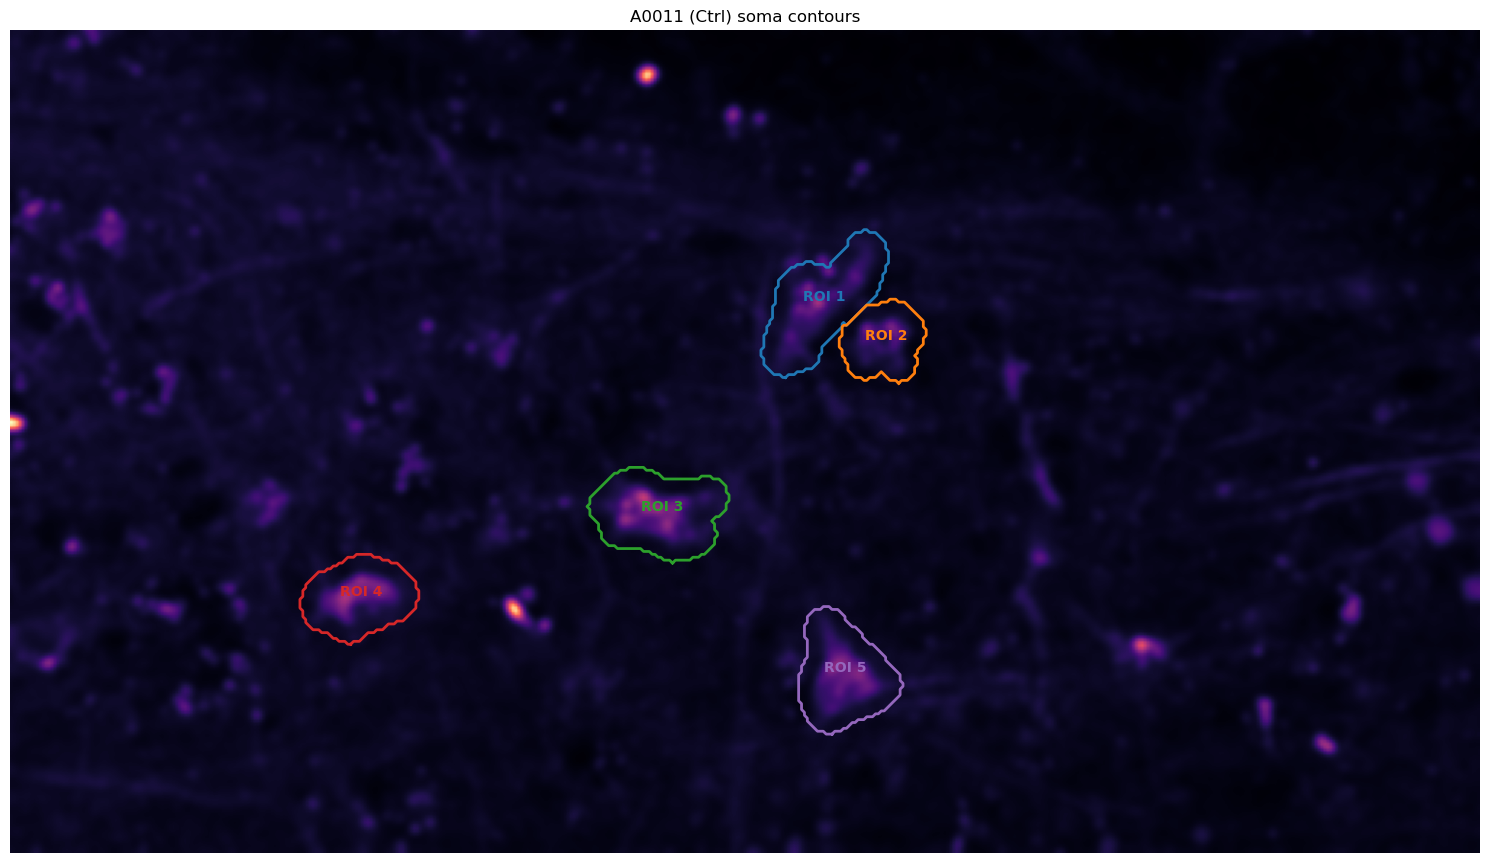

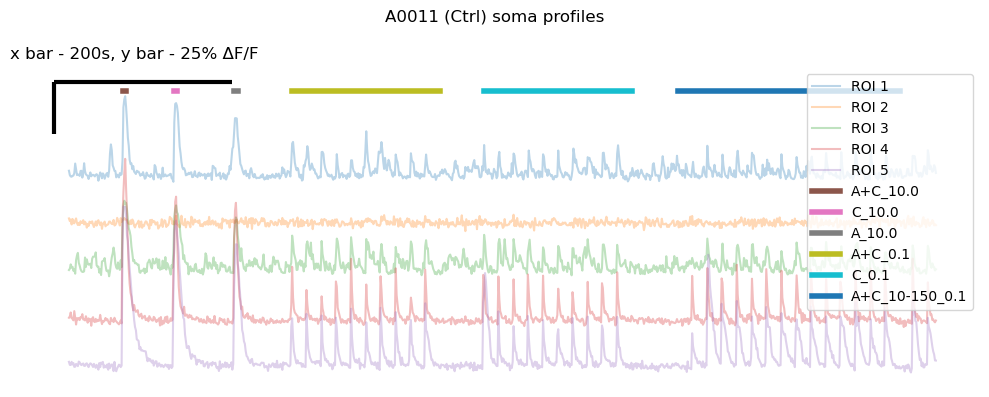

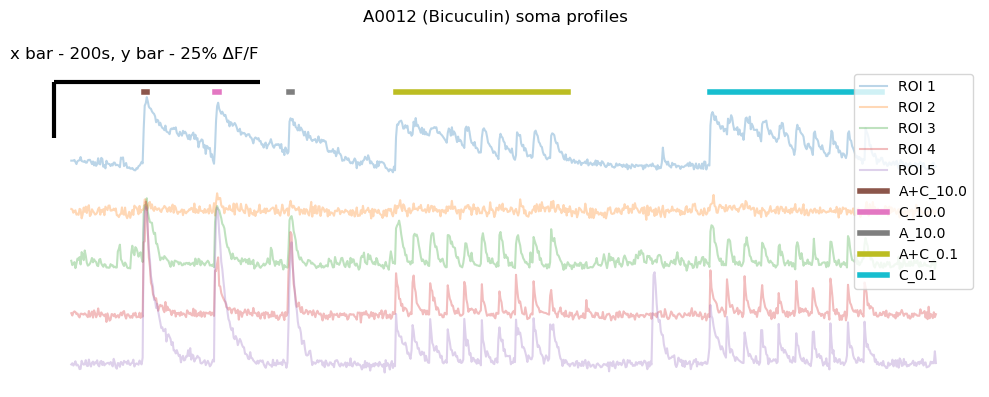

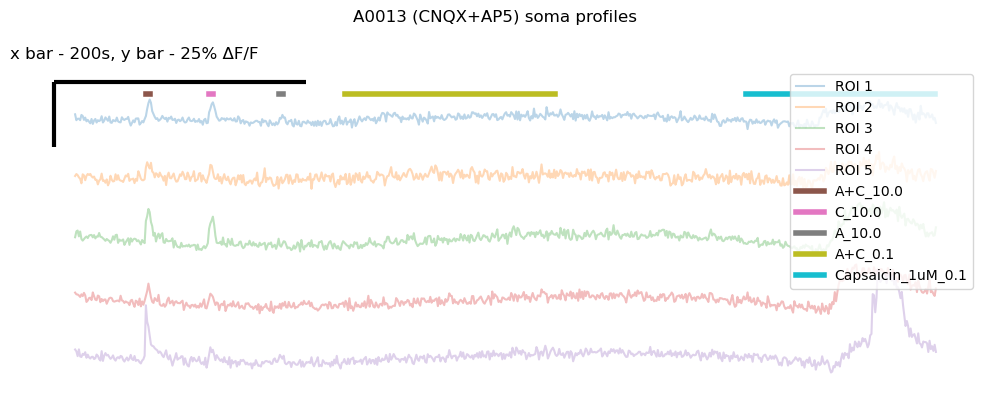

In [14]:
ctrl_reg = PostReg('A0011')
ctrl_reg.soma_mask(min_soma_area=180)
ctrl_reg.soma_profiles(soma_label=ctrl_reg.soma_label)

bicuc_reg = PostReg('A0012')
# bicuc_reg.soma_mask(min_soma_area=180)
bicuc_reg.soma_profiles(soma_label=ctrl_reg.soma_label)

noglu_reg = PostReg('A0013')
# noglu_reg.soma_mask(min_soma_area=180)
noglu_reg.soma_profiles(soma_label=ctrl_reg.soma_label)